# StarGANv2-VC Demo (Danish to English VC)

### Utils

In [1]:
"""
Imports
"""
import matplotlib.pyplot as plt
import librosa
import librosa.display


# load packages
import random
import yaml
from munch import Munch
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
import librosa
import os
import scipy.io

from Utils.ASR.models import ASRCNN
from Utils.JDC.model import JDCNet
from models import Generator, MappingNetwork, StyleEncoder

import IPython.display as ipd

%matplotlib inline


## Text-to-text translation
# !pip install translate
from translate import Translator

## Text-to-speech 
# !pip install gTTS
from gtts import gTTS
from pydub import AudioSegment
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

import sounddevice as sd
import wave as wave_lib

## Plot Spectrograms

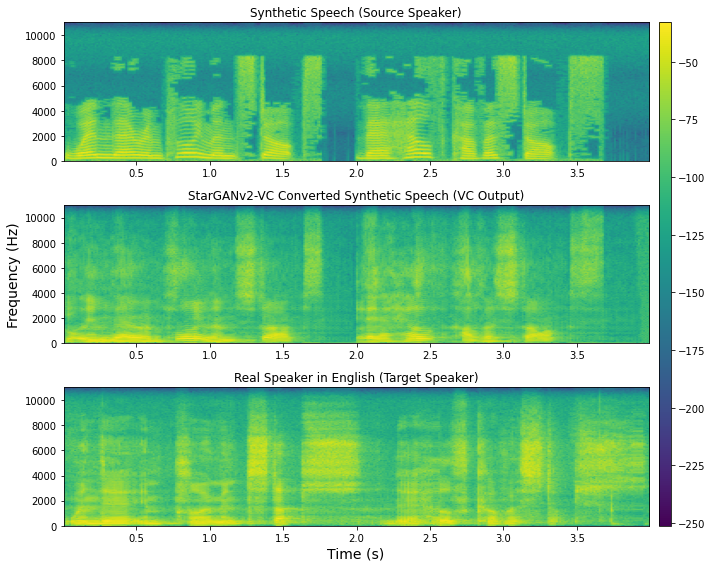

In [2]:
u_synthetic_val_17, Fs_synthetic_val_17 = librosa.load('synthetic_val_17_edited.wav')
u_synthetic_val_17_converted, Fs_synthetic_val_17_converted = librosa.load('synthetic_val_17_converted_edited.wav')
u_august_english_val_17, Fs_august_english_val_17 = librosa.load('august_english_val_17_edited.wav')
from matplotlib import gridspec

gs0 = gridspec.GridSpec(3,2, width_ratios=[10,0.2])
fig = plt.figure(figsize=(10, 8))
ax0 = fig.add_subplot(gs0[0,0])
ax1 = fig.add_subplot(gs0[1,0])
ax2 = fig.add_subplot(gs0[2,0])
cax = fig.add_subplot(gs0[:,1])
powerSpectrum, freqenciesFound, time, imageAxis = ax0.specgram(u_synthetic_val_17, Fs=Fs_synthetic_val_17, NFFT=512, noverlap=256)
ax0.set(title='Synthetic Speech (Source Speaker)')
# ax0.set_ylabel('Frequency (Hz)', fontsize=14)
powerSpectrum, freqenciesFound, time, imageAxis = ax1.specgram(u_synthetic_val_17_converted, Fs=Fs_synthetic_val_17_converted, NFFT=512, noverlap=256)
ax1.set(title="StarGANv2-VC Converted Synthetic Speech (VC Output)")
ax1.set_ylabel('Frequency (Hz)', fontsize=14)
powerSpectrum, freqenciesFound, time, imageAxis = ax2.specgram(u_august_english_val_17, Fs=Fs_august_english_val_17, NFFT=512, noverlap=256)
ax2.set(title="Real Speaker in English (Target Speaker)")
ax2.set_xlabel('Time (s)', fontsize=14)
# ax2.set_ylabel('Frequency (Hz)', fontsize=14)
fig.colorbar(imageAxis, cax=cax)
# fig.set_xlabel('Time (s)', fontsize=14)
fig.tight_layout()

## Setup code for translation and voice conversion

In [3]:
# Source: http://speech.ee.ntu.edu.tw/~jjery2243542/resource/model/is18/en_speaker_used.txt
# Source: https://github.com/jjery2243542/voice_conversion

# Binary speaker setup
# speakers = {'synthetic': 0, 'august': 1}

# Multi speaker setup
speakers = {'p240': 1, 'p232': 2, 'p236': 3, 'p259': 5, 'p256': 6, 'p273': 7, 'synthetic': 8, 'august': 9}

to_mel = torchaudio.transforms.MelSpectrogram(
    n_mels=80, n_fft=2048, win_length=1200, hop_length=300)
mean, std = -4, 4

def preprocess(wave):
    wave_tensor = torch.from_numpy(wave).float()
    mel_tensor = to_mel(wave_tensor)
    mel_tensor = (torch.log(1e-5 + mel_tensor.unsqueeze(0)) - mean) / std
    return mel_tensor

def build_model(model_params={}):
    args = Munch(model_params)
    generator = Generator(args.dim_in, args.style_dim, args.max_conv_dim, w_hpf=args.w_hpf, F0_channel=args.F0_channel)
    mapping_network = MappingNetwork(args.latent_dim, args.style_dim, args.num_domains, hidden_dim=args.max_conv_dim)
    style_encoder = StyleEncoder(args.dim_in, args.style_dim, args.num_domains, args.max_conv_dim)
    
    nets_ema = Munch(generator=generator,
                     mapping_network=mapping_network,
                     style_encoder=style_encoder)

    return nets_ema

def compute_style(path, speaker):
    wave, sr = librosa.load(path, sr=24000)
    audio, index = librosa.effects.trim(wave, top_db=30)
    if sr != 24000:
        wave = librosa.resample(wave, sr, 24000)
    mel_tensor = preprocess(wave).to('cuda')

    with torch.no_grad():
        label = torch.LongTensor([speakers[speaker]])
        ref = starganv2.style_encoder(mel_tensor.unsqueeze(1), label)
    
    return ref, label



# load F0 model
F0_model = JDCNet(num_class=1, seq_len=192)
params = torch.load("Utils/JDC/bst.t7")['net']
F0_model.load_state_dict(params)
_ = F0_model.eval()
F0_model = F0_model.to('cuda')

# load vocoder
from parallel_wavegan.utils import load_model
vocoder = load_model("Vocoder/checkpoint-400000steps.pkl").to('cuda').eval()
vocoder.remove_weight_norm()
_ = vocoder.eval()


source_wav_path = f'Data/Spectrograms_data/synthetic_val_17.wav'
audio, source_sr = librosa.load(source_wav_path, sr=24000)
audio = audio / np.max(np.abs(audio))
audio.dtype = np.float32
source_audio = preprocess(audio).to('cuda:0')


# load starganv2
# model = 'Babelfish-Split-Multi1'
model = 'final_model'
model_version = '00300'
model_path = f'Models/{model}/epoch_{model_version}.pth'

with open(f'Models/{model}/babelfish_split_multi_config.yml') as f:
    starganv2_config = yaml.safe_load(f)
starganv2 = build_model(model_params=starganv2_config["model_params"])
params = torch.load(model_path, map_location='cpu')
params = params['model_ema']
_ = [starganv2[key].load_state_dict(params[key]) for key in starganv2]
_ = [starganv2[key].eval() for key in starganv2]
starganv2.style_encoder = starganv2.style_encoder.to('cuda')
starganv2.mapping_network = starganv2.mapping_network.to('cuda')
starganv2.generator = starganv2.generator.to('cuda')

## Conversion-Only Demo

In [15]:
with torch.no_grad():
    target_speaker = 'august'
    target_path = f'Data/Babelfish_Split_Multi/{target_speaker}/130.wav'
    target, _ = compute_style(target_path, target_speaker)
    f0_feat = F0_model.get_feature_GAN(source_audio.unsqueeze(1))
    out = starganv2.generator(source_audio.unsqueeze(1), target, F0=f0_feat)
    c = out.transpose(-1, -2).squeeze().to('cuda')
    y_out = vocoder.inference(c)
    y_out = y_out.view(-1).cpu()
    wave = y_out.numpy()
    print('Converted: %s' % target_speaker)
    display(ipd.Audio(wave, rate=24000))
    print('Target: %s' % target_speaker)
    display(ipd.Audio(target_path, rate=24000))
    print('Source:')
    display(ipd.Audio(source_wav_path, rate=24000))

Converted: august


Target: august


Source:


## Audio Enhancement 

In [10]:
scipy.io.wavfile.write(f'Data/Spectrograms_data/synthetic_val_17_converted.wav', 24000, wave)

In [16]:
from speechbrain.pretrained import SpectralMaskEnhancement

denoise_model = SpectralMaskEnhancement.from_hparams(
    source="speechbrain/metricgan-plus-voicebank",
    savedir="pretrained_models/metricgan-plus-voicebank",
)

def enhance(noisy):
    wave_tensor = torch.from_numpy(noisy).float().unsqueeze(0)
    # Add relative length tensor
    enhanced = denoise_model.enhance_batch(wave_tensor, lengths=torch.tensor([1.]))
    return enhanced

In [17]:
print('Converted: %s' % target_speaker)
display(ipd.Audio(enhance(wave), rate=24000))
print('Target: %s' % target_speaker)
display(ipd.Audio(target_path, rate=24000))
print('Source:')
display(ipd.Audio(source_wav_path, rate=24000))

Converted: august


Target: august


Source:


In [7]:


for i in range(20):
    source_wav_path = f'Data/val/tts_val/{str(i+1)}.wav'

    audio, source_sr = librosa.load(source_wav_path, sr=24000)
    audio = audio / np.max(np.abs(audio))
    audio.dtype = np.float32
    source_audio = preprocess(audio).to('cuda:0')
    
    with torch.no_grad():
        target_speaker = 'august'
        target_path = f'Data/Babelfish_Split_Multi/{target_speaker}/130.wav'
        # target_path = f'Data/val/august_speech_english_val/{str(i+1)}.wav'
        target, _ = compute_style(target_path, target_speaker)
        f0_feat = F0_model.get_feature_GAN(source_audio.unsqueeze(1))
        out = starganv2.generator(source_audio.unsqueeze(1), target, F0=f0_feat)
        c = out.transpose(-1, -2).squeeze().to('cuda')
        y_out = vocoder.inference(c)
        y_out = y_out.view(-1).cpu()
        wave = y_out.numpy()
    
    target_wav_path = f'Data/val/tts_val_converted_nontrainedtarget/{str(i+1)}.wav'
    # wave = ipd.Audio(enhance(wave), rate=24000)
    # wave = enhance(wave).numpy()
    scipy.io.wavfile.write(target_wav_path, 24000, wave)

# Take danish speech, STT into string, translate, TTS into synthetic speech and voice conversion

In [7]:
def transcribe_danish_audio(audio_file_path, sampling_rate=16000):
    # load model and tokenizer
    processor = Wav2Vec2Processor.from_pretrained(
        "chcaa/xls-r-300m-danish-nst-cv9")
    model = Wav2Vec2ForCTC.from_pretrained(
        "chcaa/xls-r-300m-danish-nst-cv9")

    wave, sr = librosa.load(audio_file_path, sr=sampling_rate)

    # tokenize
    input_values = processor(wave, return_tensors="pt", padding="longest", sampling_rate=sampling_rate).input_values  # Batch size 1

    # retrieve logits
    logits = model(input_values).logits

    # take argmax and decode
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    return ' '.join(transcription)

CHANNELS = 2
RATE = 16000
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "output.wav"


def record_audio_file():
    recording = sd.rec(int(RECORD_SECONDS * RATE), samplerate=RATE, channels=CHANNELS)

    print("Recording...")
    sd.wait()  # Wait until recording is finished
    print("Finished recording.")

    # Write recording to file
    with wave_lib.open(WAVE_OUTPUT_FILENAME, "wb") as f:
        f.setnchannels(CHANNELS)
        f.setsampwidth(2)
        f.setframerate(RATE)
        f.writeframes(recording)

    return WAVE_OUTPUT_FILENAME

In [16]:
source_speaker = 'synthetic'
source_wav_path = f'Data/Babelfish_Split_Multi/{source_speaker}/1.wav'



### DEFINE DANISH INPUT SPEECH
# danish_speech_wav = record_audio_file()
danish_speech_wav = 'demo_wavs/output.wav'


### SPEECH TO TEXT
source_text = transcribe_danish_audio(danish_speech_wav)
if not source_text:
    source_text = "Ingen tale blev registreret."


### TRANSLATION

## Define the translator
text_translator = Translator(from_lang='da', to_lang='en')

## Translate the text
translated_text = text_translator.translate(source_text)

## Print source and translated text if specific
print('Source text: ', source_text)
print('Translated text: ', translated_text)


### TEXT TO SPEECH
## Read aloud translated text using Google Text-to-Speech
TTS_speech = gTTS(text=translated_text, lang='en', slow=False)
TTS_speech.save('TTS_speech.mp3')

## Convert mp3 to wav, as gTTS only supports mp3
sound = AudioSegment.from_mp3('TTS_speech.mp3')
sound.export('TTS_speech.wav', format="wav")


### VOICE CONVERSION
source_wav_path = f'TTS_speech.wav'
audio, source_sr = librosa.load(source_wav_path, sr=24000)
audio = audio / np.max(np.abs(audio))
audio.dtype = np.float32
source_audio = preprocess(audio).to('cuda:0')

with torch.no_grad():
    target_speaker = 'august'
    target_path = f'Data/Babelfish_Split_Multi/{target_speaker}/130.wav'
    target, _ = compute_style(target_path, target_speaker)
    f0_feat = F0_model.get_feature_GAN(source_audio.unsqueeze(1))
    out = starganv2.generator(source_audio.unsqueeze(1), target, F0=f0_feat)
    c = out.transpose(-1, -2).squeeze().to('cuda')
    y_out = vocoder.inference(c)
    y_out = y_out.view(-1).cpu()
    wave = y_out.numpy()
    print('Danish Speech:')
    display(ipd.Audio(danish_speech_wav, rate=24000))
    print("")
    print('Synthetic TTS English Speech:')
    display(ipd.Audio(source_wav_path, rate=24000))
    print("")
    print('StarGANv2-VC Converted English Speech:')
    display(ipd.Audio(wave, rate=24000))


Source text:  jeg synes at danmark gjorde det ekstremt dårligt til vem i fodbold i år
Translated text:  i think that Denmark did extremely badly to who in football this year
Danish Speech:



Synthetic TTS English Speech:



StarGANv2-VC Converted English Speech:
